In [1]:
from numpy.fft import fft, ifft, hfft
from scipy.signal import lfilter
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
from IPython.display import Audio
from scipy import signal
from helpers import *

figsize=(10,5)

# The building blocks of a reverberator

In [2]:
def tap_delay(x, delay_IR, pole=False):
    
    delays = 0
    
    for i in range(delay_IR.size):
        delays += delay_IR[i] * np.concatenate((np.full((i), 0.), x))[:x.size]
        
    if pole==True:
        b = delay_IR
        a = np.ones(1)
        freq_response(b,a)
        return zplane(b,a)
    
    return delays 

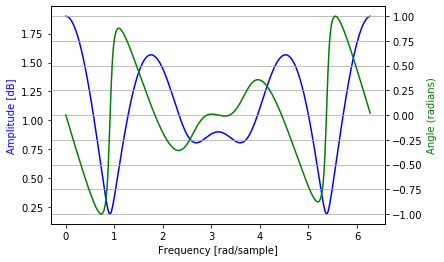

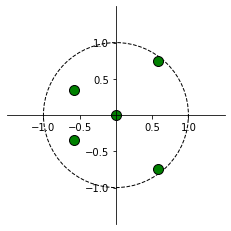

(array([ 0.57809876+0.7419058j ,  0.57809876-0.7419058j ,
        -0.57809876+0.34347074j, -0.57809876-0.34347074j,
         0.        +0.j        ]),
 array([], dtype=float64),
 1.0)

In [3]:
tap_delay(np.array([1]), np.array([1, 0, 0, .5, .4, 0]), pole=True)

In [4]:
def comb_filter(x, g, M, pole=False):
    
    b = np.repeat(np.conj(g),1)
    a = np.zeros(M+1)
    a[0] = 1
    a[M] = g
    
    if pole==True:
        freq_response(b,a)
        return zplane(b,a)
    
    x = lfilter(b, a, x)
    return x / np.max(np.abs(x))

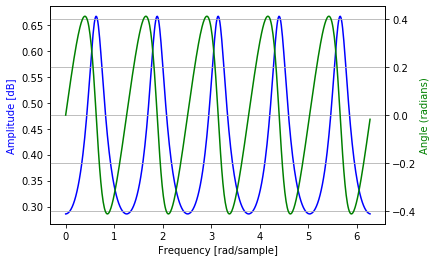

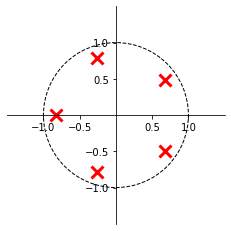

(array([], dtype=float64),
 array([-0.83255321+0.j        , -0.25727309+0.79180515j,
        -0.25727309-0.79180515j,  0.67354969+0.4893625j ,
         0.67354969-0.4893625j ]),
 1.0)

In [5]:
comb_filter(np.array([1]), .4, 5, pole=True)

In [6]:
def allpass_comb_filter(x, g, M, pole=False):
    
    b = np.zeros(M+1)
    b[0] = np.conj(g)
    b[M] = 1
    a = np.zeros(M+1)
    a[0] = 1
    a[M] = g
    
    if pole==True:
        freq_response(b,a)
        return zplane(b,a)
    
    x = lfilter(b, a, x)
    return x / np.max(np.abs(x))

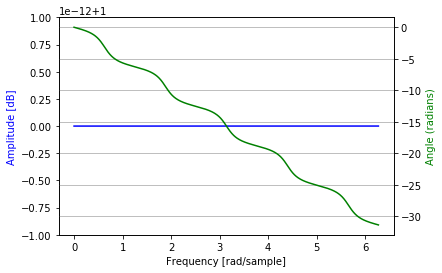

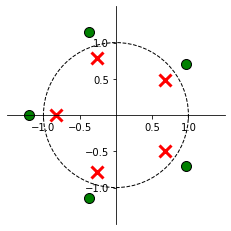

(array([-1.20112443+0.j        , -0.37116786+1.14233722j,
        -0.37116786-1.14233722j,  0.97173008+0.70600323j,
         0.97173008-0.70600323j]),
 array([-0.83255321+0.j        , -0.25727309+0.79180515j,
        -0.25727309-0.79180515j,  0.67354969+0.4893625j ,
         0.67354969-0.4893625j ]),
 1.0)

In [7]:
allpass_comb_filter(np.array([1]), .4, 5, pole=True)

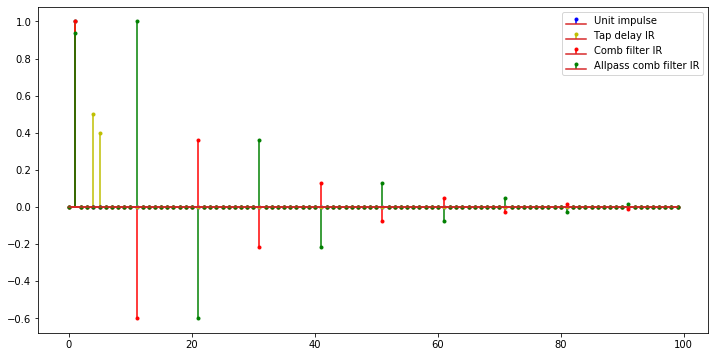

In [8]:
impulse = np.zeros(100)
impulse[1] = 1

plt.figure(figsize=(12,6))
plt.stem(impulse, label = "Unit impulse", linefmt='blue', markerfmt='b.',use_line_collection=True)
plt.stem( tap_delay(impulse, np.array([1, 0, 0, .5, .4])),  linefmt='y', label="Tap delay IR", markerfmt='y.',use_line_collection=True)
plt.stem( comb_filter(impulse, 0.6, 10), label="Comb filter IR", linefmt='red', markerfmt='r.',use_line_collection=True)
plt.stem( allpass_comb_filter(impulse, 0.6, 10), label="Allpass comb filter IR", linefmt='g', markerfmt="g.", use_line_collection=True)
plt.legend()
plt.show()

# Schroeder's reverberator

In [9]:
def schroeder_reverberator(x):
    
    # Parallel stage
    x = ( comb_filter(x, 0.805, 1801) 
        + comb_filter(x, 0.827, 1478) 
        + comb_filter(x, 0.783, 2011) 
        + comb_filter(x, 0.764, 2123) ) / 4
    
    # Series stage
    x = allpass_comb_filter(x, 0.7, 225)
    x = allpass_comb_filter(x, 0.7, 82)
    x = allpass_comb_filter(x, 0.7, 22)
    
    return x

# Moorer's reverberator

In [10]:
def moorer_reverberator(x):

    # Tap delay
    delay_array = np.zeros(150)
    delay_array[40]  = .4
    delay_array[70]  = .3
    delay_array[149] = .2
    x = tap_delay(x, delay_array)
    early_reflections = x
    
    # Parallel stage
    x = ( comb_filter(x, 0.805, 1801) 
        + comb_filter(x, 0.827, 1478) 
        + comb_filter(x, 0.783, 2011) 
        + comb_filter(x, 0.764, 2123) ) / 4
    
    # Allpass stage
    x = allpass_comb_filter(x, 0.7, 225)
    
    # Delay
    late_reverb = np.concatenate((np.full(1000, 0.), x))[:x.size]
    
    return early_reflections + late_reverb

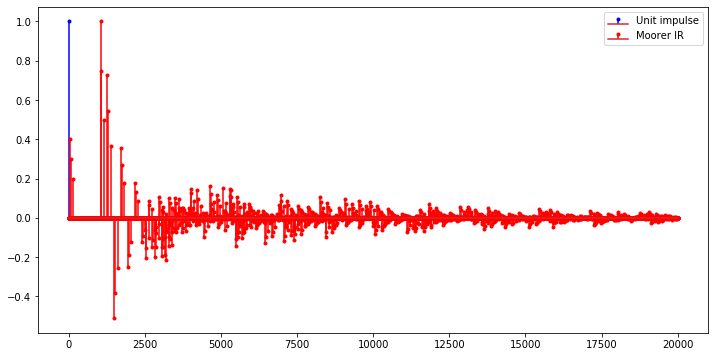

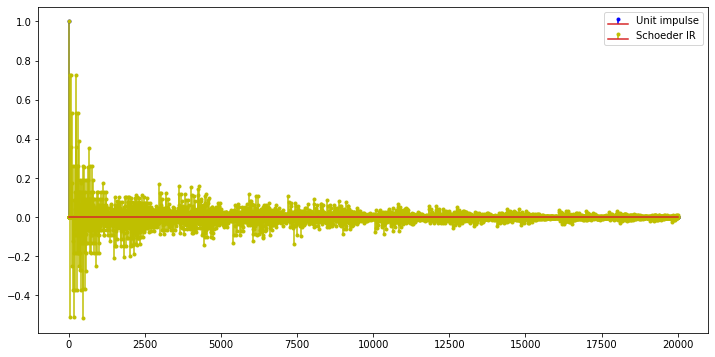

In [11]:
impulse = np.zeros(20000)
impulse[1] = 1

plt.figure(figsize=(12,6))
plt.stem(impulse, label = "Unit impulse",  linefmt='blue', markerfmt='b.',use_line_collection=True)
#plt.stem( schroeder_reverberator(impulse),  linefmt='y', label="Schoeder IR", markerfmt='y.',use_line_collection=True)
plt.stem( moorer_reverberator(impulse), label="Moorer IR", linefmt='red', markerfmt='r.',use_line_collection=True)
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.stem(impulse, label = "Unit impulse",  linefmt='blue', markerfmt='b.',use_line_collection=True)
plt.stem( schroeder_reverberator(impulse),  linefmt='y', label="Schoeder IR", markerfmt='y.',use_line_collection=True)
#plt.stem( moorer_reverberator(impulse), label="Moorer IR", linefmt='red', markerfmt='r.',use_line_collection=True)
plt.legend()
plt.show()

# Testing with guitar sample

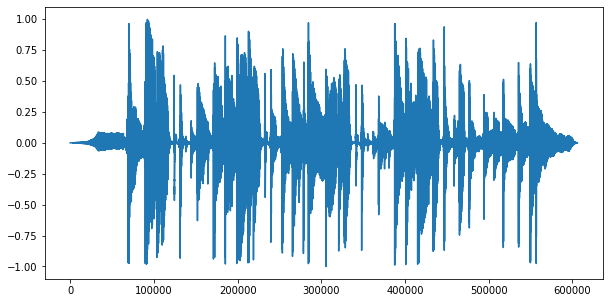

In [12]:
fs, data = wavfile.read('samples/guitar.wav')
guitar_sample = np.array(data, dtype=np.float32)
guitar_sample /= np.max(np.abs(guitar_sample) )
plt.figure(figsize=figsize)
plt.plot(guitar_sample)
Audio("samples/guitar.wav", autoplay=False)

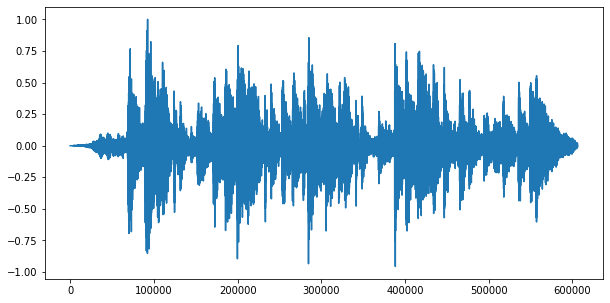

In [15]:
guitar_schroeder = schroeder_reverberator(guitar_sample)
guitar_schroeder /= np.max(np.abs(guitar_schroeder) )
plt.figure(figsize=figsize)
plt.plot(guitar_schroeder)
wavfile.write('samples/guitar_schroeder.wav', fs, (0x7FFF * guitar_schroeder).astype(np.int16))
Audio("samples/guitar_schroeder.wav", autoplay=False)

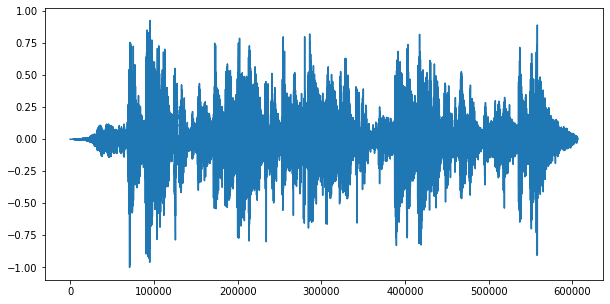

In [16]:
guitar_moorer = moorer_reverberator(guitar_sample)
guitar_moorer /= np.max(np.abs(guitar_moorer) )
plt.figure(figsize=figsize)
plt.plot(guitar_moorer)
wavfile.write('samples/guitar_moorer.wav', fs, (0x7FFF * guitar_moorer).astype(np.int16))
Audio("samples/guitar_moorer.wav", autoplay=False)